In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from PyPDF2 import PdfReader

import warnings
warnings.filterwarnings('ignore')

from ACSdata_API import get_ACS5data

### Equity Consideration in Electric Vehicle Chargers

The following analysis follow research "Using the Mapping Tools to Prioritize Electric Vehicle Charger Benefits to Underserved Communities" by Argonne National Laboratory

**Goals:** 

1) Implement Justice40 Goals to faciliate the construction on Disadvantaged Communities (DACs)
2) Identify census tract to benefit EEJ communities.

Four Scenarios conducted followed by the resesarch methodology

**Dataset**

1) EVSE density within 15 minutes driving/walking (calculated via TomTom API)
2) NYC Census Tract
3) NYS Disadvantaged Communities (DACs) List [**Scenario B1**]
4) People of Color From ACS 5-Year 2022 [**Scenario B2**]
5) Household to Proverty Level From ACS 5-Year 2022 [**Scenario B2**]
6) Multi-Family Homes (5 units or moree) From ACS 5-Year 2022 [**Scenario B3**]
7) Renter-occupied Housing From ACS 5-Year 2022 [**Scenario B3**]

#### EVSE density

In [562]:
Drive_Range = gpd.read_file('EVSEdensity_15drive.geojson')
Walk_Range = pd.read_csv('EVSEdensity_15walk.csv')
Walk_Range['GEOID'] = Walk_Range['GEOID'].astype('str')

## loading census tract for plotting
ct = gpd.read_file('census_tract/ny_census_tract.shp')

### Scenario B1

**Disadvantaged Communities (DACs)**

NYS Criteria: https://climate.ny.gov/Resources/Disadvantaged-Communities-Criteria 

(Source: https://climate.ny.gov/-/media/Project/Climate/Files/Disadvantaged-Communities-Criteria/List-of-Disadvantaged-Communities.pdf)

In [526]:
## Disadvantaged Community
reader = PdfReader("List-of-Disadvantaged-Communities.pdf")
number_of_pages = len(reader.pages)

nys_dac = []
for p in range(number_of_pages):
    text = reader.pages[p].extract_text()
    nys_dac += [txt.split('  ') for txt in text.splitlines() if txt.split('  ')[0].startswith('36') ]

nys_dac = [d[:4] if len(d)==5 else d for d in nys_dac]
dac_nys = pd.DataFrame(nys_dac, columns=['GEOID','Region','County','PlaceName'])

dac_nyc = dac_nys[dac_nys['GEOID'].apply(lambda s: s[2:5] in ['005','047','061','081','085'] )]
dac_nyc

,GEOID,Region,County,PlaceName
25,36005000100,New York City,Bronx,New York city
26,36005000200,New York City,Bronx,New York city
27,36005000400,New York City,Bronx,New York city
28,36005001600,New York City,Bronx,New York city
29,36005001900,New York City,Bronx,New York city
...,...,...,...,...
1475,36085030301,New York City,Richmond,New York city
1476,36085030302,New York City,Richmond,New York city
1477,36085031901,New York City,Richmond,New York city
1478,36085031902,New York City,Richmond,New York city


<Axes: >

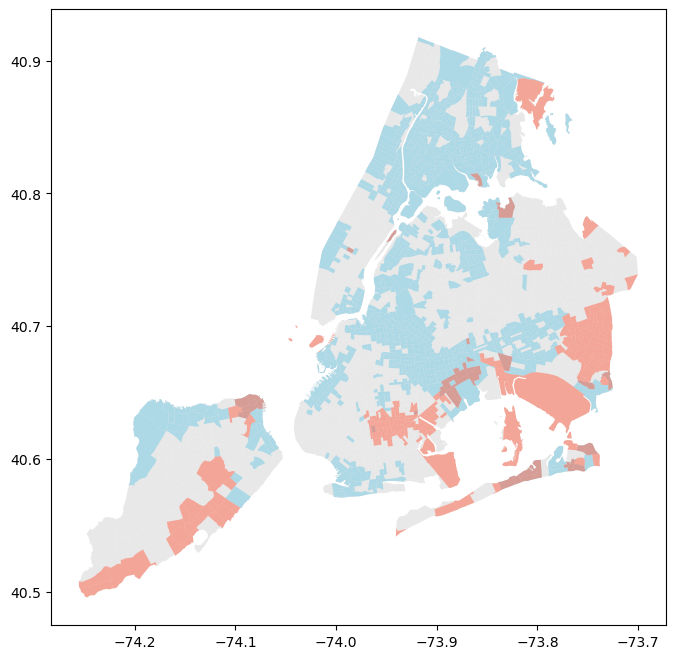

In [527]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8))
ct.plot(ax=ax, color='lightgrey', alpha=0.5)
ct.merge(dac_nyc[['GEOID']], on='GEOID', how="right").plot(ax=ax, color="lightblue", missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                                                        "edgecolor": "grey",
                                                                                        "linewidth": 0.3,
                                                                                        "alpha": 0.5,
                                                                                        "hatch": "////",
                                                                                        },)
ct.merge(Drive_Range[Drive_Range['Count']<=20][['GEOID','Count']], on='GEOID',how="inner").plot(ax=ax,column="Count", color="tomato", alpha=0.5)

### Scenario B2

**Percent people of color**

The percent of individuals in a block group who list their racial status as a race other than white alone and/or list their ethnicity as Hispanic or Latino. That is, all people other than non-Hispanic white-alone individuals. The word "alone" in this case indicates that the person is of a single race, not multiracial.

**Population and Ethnicity**

- B01003_001E: Population
- B02001_001E: Race
- B02001_002E: While Alone
- B02001_003E: Black or African American Alone

**Percent low-income**

Percent of individuals whose ratio of household income to poverty level in the past 12 months was less than 2 (as a fraction of individuals for whom ratio was determined).

**Income to Poverty Level**

Ratio of Income to Poverty level in the Past 12 Months

- C17002_001E: Total
- C17002_002E: Under .50
- C17002_003E: .50 to .99
- C17002_004E: 1.00 to 1.24
- C17002_005E: 1.25 to 1.49
- C17002_006E: 1.50 to 1.84
- C17002_007E: 1.85 to 1.99

In [548]:
### Plot Distribution and Get Percentile
def GetPercentile(state_df, city_df, ptg_col, pctg):
    pct = np.percentile(np.array(state_df[ptg_col]), pctg)

    #histograms of statewide and citywide distributions
    plt.hist(state_df[ptg_col],bins=30,alpha=0.7, color="lightblue", label='state')
    plt.hist(city_df[ptg_col],bins=30,alpha=0.5, color="orange", label='city')

    plt.axvline(x = pct, color='tomato',linestyle='dashed')

    plt.legend()
    plt.title('{} {}th percentile by state: {}'.format(ptg_col, pctg, round(pct,3)))
    plt.show()

    return pct

In [529]:
##people of color
kwd = {
    'Population':'B01003_001E,B02001_001E,B02001_002E,B02001_003E',
    'IncomeToPovertyLevel':'C17002_001E,C17002_002E,C17002_003E,C17002_004E,C17002_005E,C17002_006E,C17002_007E'
}
kwd_columns = {
    'Population':['Pop','Race','White','Black_Africa'],
    'IncomeToPovertyLevel': ['Total','Under05','050to099','100to124','125to149','150to184','185to199'] 
}


In [535]:
color_nys = get_ACS5data(kwd['Population'], kwd_columns['Population'], NYS=True)
color_df = get_ACS5data(kwd['Population'], kwd_columns['Population'])

color_nys = color_nys[color_nys['Pop']!=0]
color_df = color_df[color_df['Pop']!=0]

color_nys['color_ptg'] = 1 - color_nys['White']/color_nys['Race']
color_df['color_ptg'] = 1 - color_df['White']/color_df['Race']

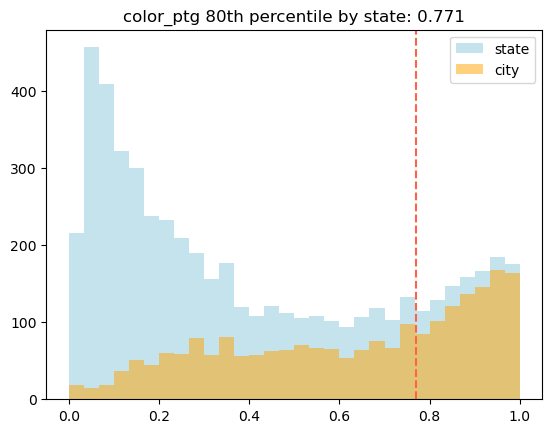

In [547]:
color_pct = GetPercentile(color_nys, color_df, 'color_ptg', 80)

<Axes: >

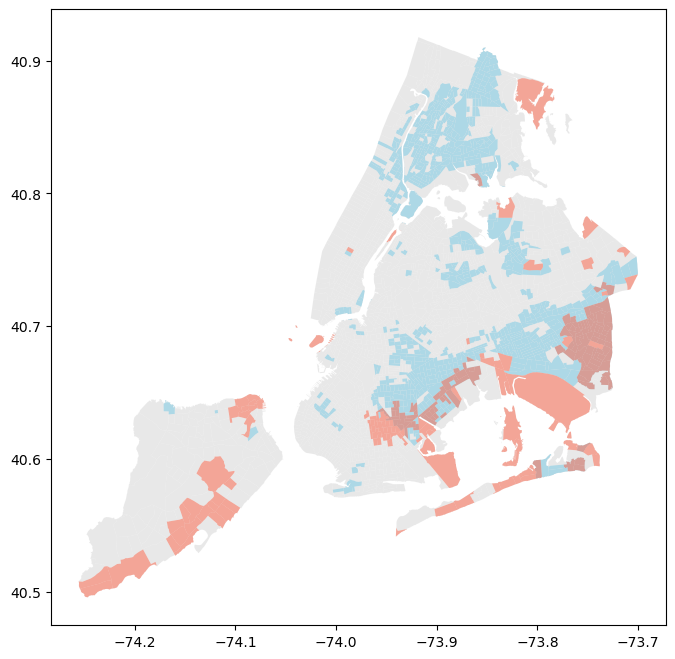

In [549]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8))
ct.plot(ax=ax, color='lightgrey', alpha=0.5)
ct.merge(color_df[ color_df['color_ptg']>= color_pct ][['GEOID','color_ptg']], on='GEOID',how="inner").plot(ax=ax,color="lightblue")
ct.merge(Drive_Range[Drive_Range['Count']<=20][['GEOID','Count']], on='GEOID',how="inner").plot(ax=ax,column="Count", color="tomato", alpha=0.5)

In [550]:
### low income
income_nys = get_ACS5data(kwd['IncomeToPovertyLevel'], kwd_columns['IncomeToPovertyLevel'], NYS=True)
income_df = get_ACS5data(kwd['IncomeToPovertyLevel'], kwd_columns['IncomeToPovertyLevel'])

income_nys = income_nys[income_nys['Total']!=0]
income_df = income_df[income_df['Total']!=0]

income_nys['low_income_ptg'] = income_nys.iloc[:, ~income_nys.columns.isin(['Total','GEOID'])].sum(axis=1)/income_nys['Total']
income_df['low_income_ptg'] = income_df.iloc[:, ~income_df.columns.isin(['Total','GEOID'])].sum(axis=1)/income_df['Total']

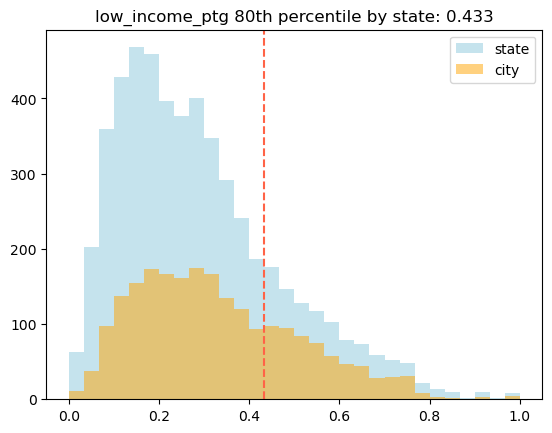

In [552]:
income_pct = GetPercentile(income_nys, income_df, 'low_income_ptg', 80)

<Axes: >

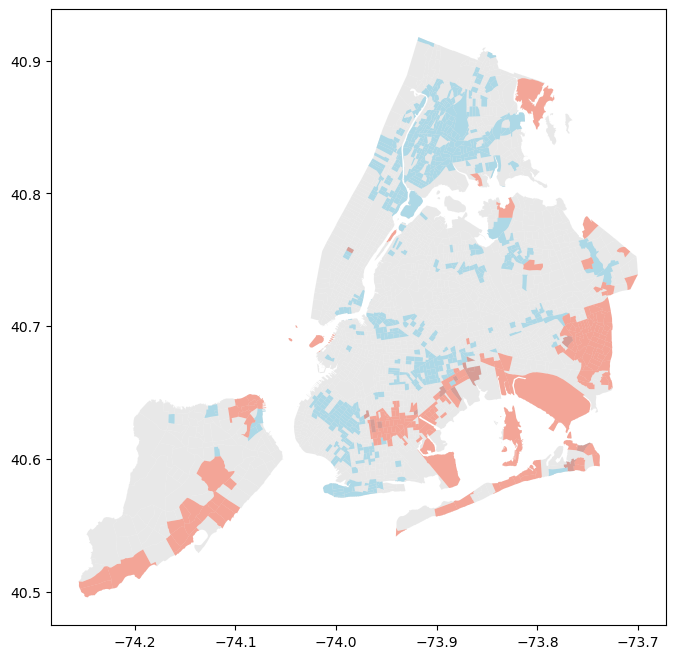

In [553]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8))
ct.plot(ax=ax, color='lightgrey', alpha=0.5)

ct.merge( income_df[income_df['low_income_ptg']>=income_pct ][['GEOID','low_income_ptg']], on='GEOID',how="inner")\
    .plot(ax=ax,color="lightblue")
ct.merge(Drive_Range[Drive_Range['Count']<=20][['GEOID','Count']], on='GEOID',how="inner").plot(ax=ax,column="Count", color="tomato", alpha=0.5)

### Scenario B3

use the MFH share of all housing types and rental share of all housing ownership types as the indicators

**Percentage Multi-Family Homes**

MFH (five units or more) B25024 in ACS

**Unit in Structure**

- B25024_001E: Total
- B25024_002E: Total:: 1, detached
- B25024_003E: Total:: 1, attached
- B25024_004E: Total:: 2
- B25024_005E: Total:: 3 or 4

**Percentage rental housing**

**Total Population in Occupied Housing Units by Tenure by Units in Structure**

**Total Population in Occupied Housing Units by Tenure**

- B25008_001E: Total
- B25008_002E: Total:: Owner occupied
- B25008_003E: Total:: Renter occupied

In [555]:
#MFH
kwd = {
    'UnitInStructure':'B25024_001E,B25024_002E,B25024_003E,B25024_004E,B25024_005E',
    'RentalHousing':'B25008_001E,B25008_002E,B25008_003E'
}
kwd_columns = {
    'UnitInStructure':['Total','Total_1d','Total_1a','Total_2','Total_3_4'],
    'RentalHousing': ['Total','Onwer','Renter']
}

In [556]:
#multi-family homes
mfh_nys = get_ACS5data(kwd['UnitInStructure'], kwd_columns['UnitInStructure'], NYS=True)
mfh_df = get_ACS5data(kwd['UnitInStructure'], kwd_columns['UnitInStructure'])

mfh_nys = mfh_nys[mfh_nys['Total']!=0]
mfh_df = mfh_df[mfh_df['Total']!=0]

mfh_nys['mhf_ptg'] = 1 - (mfh_nys.iloc[:, ~mfh_nys.columns.isin(['Total','GEOID'])].sum(axis=1)/mfh_nys['Total'])
mfh_df['mhf_ptg'] = 1 - (mfh_df.iloc[:, ~mfh_df.columns.isin(['Total','GEOID'])].sum(axis=1)/mfh_df['Total'])

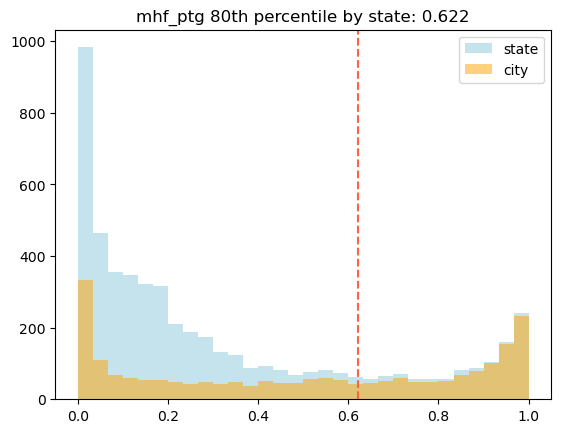

In [558]:
mfh_pct = GetPercentile(mfh_nys, mfh_df, 'mhf_ptg', 80)

<Axes: >

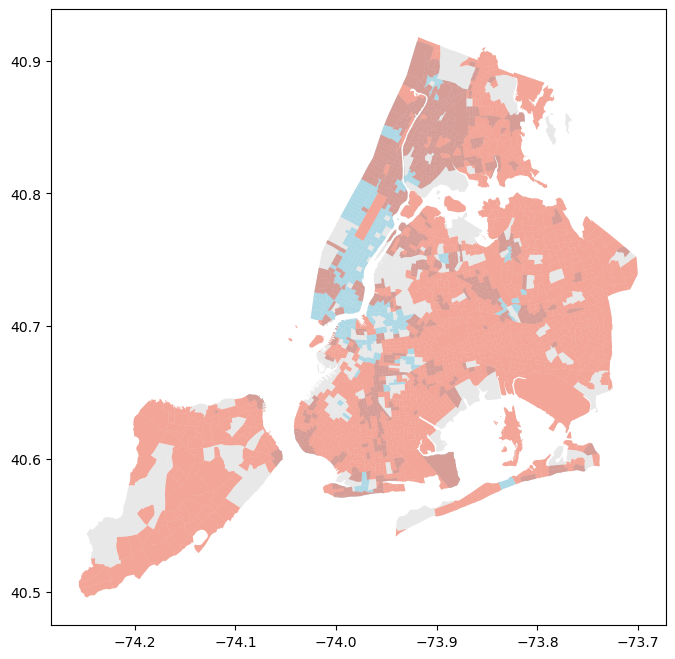

In [563]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8))
ct.plot(ax=ax, color='lightgrey', alpha=0.5)

ct.merge(mfh_df[ mfh_df['mhf_ptg']>=mfh_pct ][['GEOID','mhf_ptg']], on='GEOID',how="inner").plot(ax=ax,color="lightblue")

ct.merge(Walk_Range[Walk_Range['Walk15_EVSE']<=10][['GEOID','Walk15_EVSE']], on='GEOID',how="inner").plot(ax=ax,column="Walk15_EVSE", color="tomato", alpha=0.5)

In [564]:
## rental housing
rental_nys = get_ACS5data(kwd['RentalHousing'], kwd_columns['RentalHousing'], NYS=True)
rental_df = get_ACS5data(kwd['RentalHousing'], kwd_columns['RentalHousing'])

rental_nys = rental_nys[rental_nys['Total']!=0]
rental_df = rental_df[rental_df['Total']!=0]

rental_nys['rental_ptg'] = rental_nys['Renter']/rental_nys['Total']
rental_df['rental_ptg'] = rental_df['Renter']/rental_df['Total']

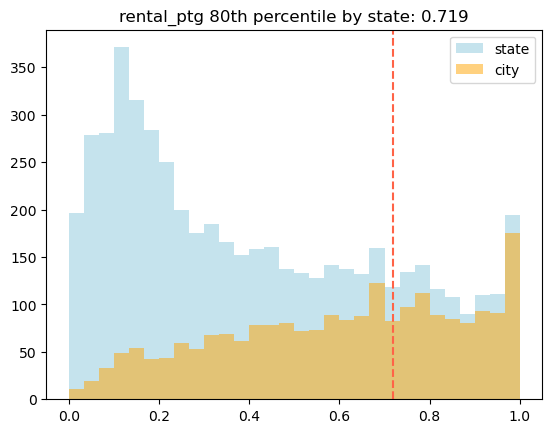

In [565]:
rental_pct = GetPercentile(rental_nys, rental_df, 'rental_ptg', 80)

<Axes: >

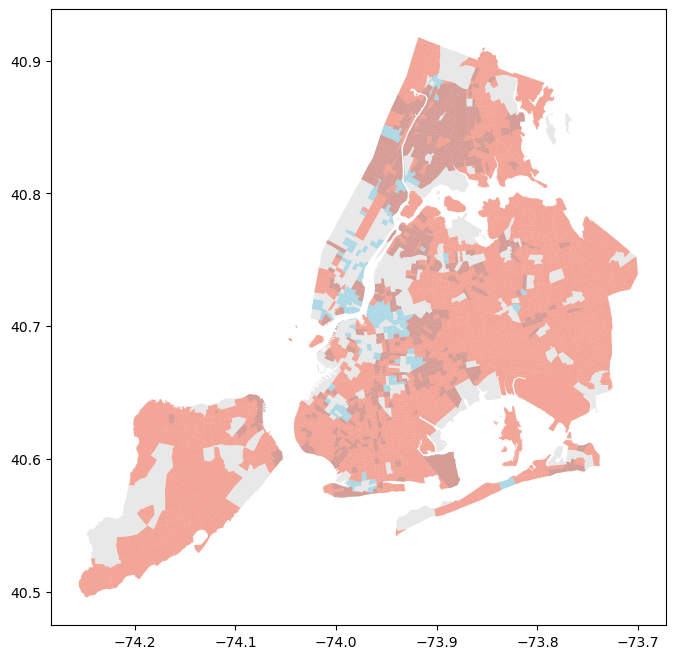

In [566]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8))
ct.plot(ax=ax, color='lightgrey', alpha=0.5)

ct.merge(rental_df[ rental_df['rental_ptg']>= rental_pct ][['GEOID','rental_ptg']], on='GEOID',how="inner").plot(ax=ax,color="lightblue")

ct.merge(Walk_Range[Walk_Range['Walk15_EVSE']<=10][['GEOID','Walk15_EVSE']], on='GEOID',how="inner").plot(ax=ax,column="Walk15_EVSE", color="tomato", alpha=0.5)